In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import SpectralEmbedding
import scipy.optimize as optimize

In [25]:
expr = pd.read_csv('data.txt', sep='\t')
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
y_train = expr.values[:,expr.shape[1]-1]

In [26]:
filename="check1.txt"

prob = []
        
with open(filename, 'r') as f:
    for line in f.readlines():
        f=list(map(float, line.split()))
        prob.append(f)
prob=np.array(prob)

In [15]:
P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
MIN_DIST = 0.25
x = np.linspace(0, 3, 300) #np array of 300 linearly spaced elements from 0 to 3  

In [16]:
def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

In [17]:
dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1] 

Hyperparameters a = 1.1214363425627392 and b = 1.0574998764478827


In [18]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [19]:
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

In [20]:
def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact=np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

[[-0.00308281 -0.00215417]
 [-0.00313979 -0.00239993]
 [-0.00311095 -0.00077264]
 ...
 [-0.00302381 -0.0002924 ]
 [ 0.01077844  0.00101295]
 [-0.00287111  0.00074993]]
Running Gradient Descent: 

Cross-Entropy = 23.039068385500087 after 0 iterations
Cross-Entropy = 1.8014156707489342 after 10 iterations
Cross-Entropy = 1.2858340525127954 after 20 iterations
Cross-Entropy = 1.097373320135421 after 30 iterations
Cross-Entropy = 1.1120417655965826 after 40 iterations
Cross-Entropy = 1.1124826700788055 after 50 iterations
Cross-Entropy = 1.1663583496047818 after 60 iterations
Cross-Entropy = 1.1010922335470237 after 70 iterations
Cross-Entropy = 1.110566227284003 after 80 iterations
Cross-Entropy = 1.1334230229367308 after 90 iterations
Cross-Entropy = 1.1878030276422789 after 100 iterations
Cross-Entropy = 1.1327885835123581 after 110 iterations
Cross-Entropy = 1.0689928528239292 after 120 iterations
Cross-Entropy = 1.1892419457890977 after 130 iterations
Cross-Entropy = 1.166101102072467

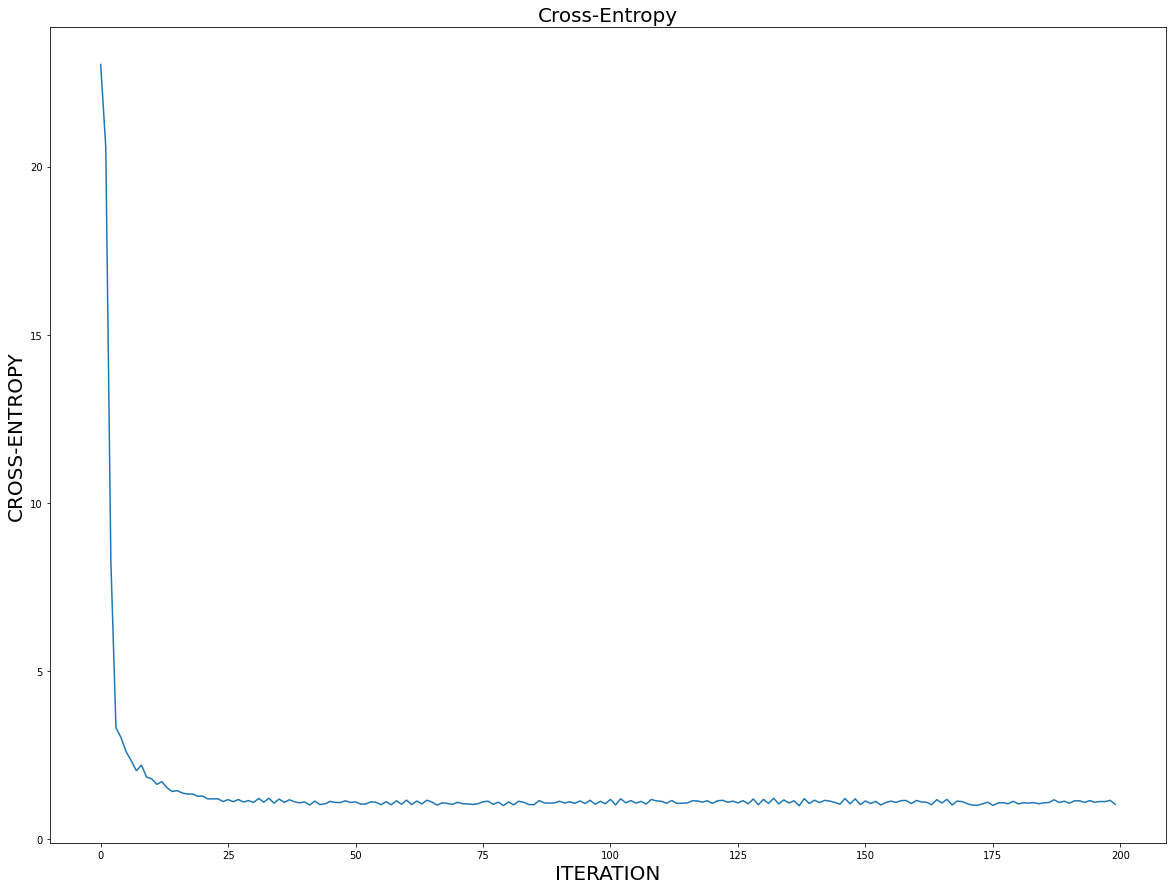

In [30]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
print(y)
CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig("UMAP"+str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

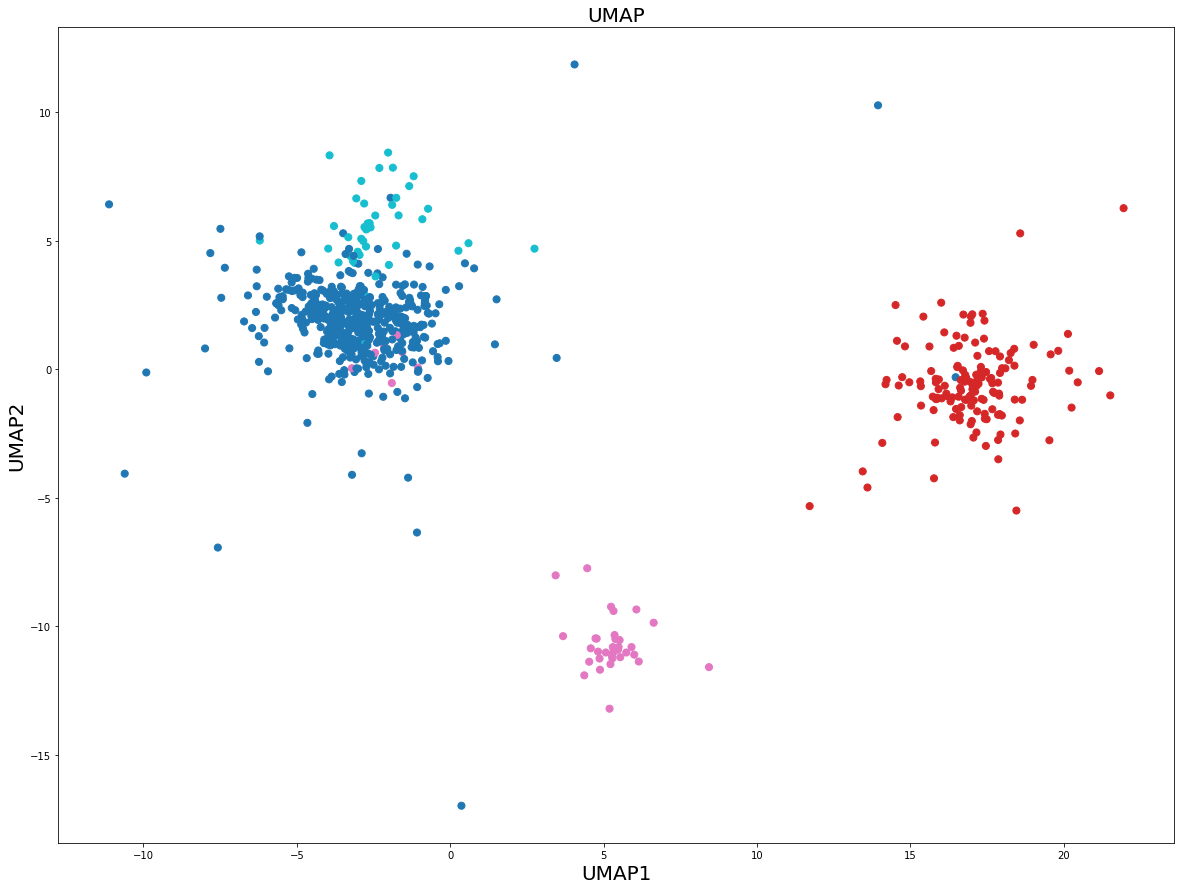

In [32]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP", 
          fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()